classification of animals of 10 types using deep learnimg

In [1]:
import pandas as pd 
import numpy as np


In [3]:
import os  #for manpulating directories
import random # for shuffling images
import cv2

In [4]:
# Check if DirectML is available
from tensorflow.python.client import device_lib
def get_available_devices():
    devices = device_lib.list_local_devices()
    for device in devices:
        print(device.name, device.device_type)

# List all available devices
get_available_devices()

/device:CPU:0 CPU
/device:DML:0 DML


In [5]:
# Check if a GPU is available with DirectML
if any(device.device_type == 'DML' for device in device_lib.list_local_devices()):
    print("DirectML is available and a DML is detected.")
else:
    print("DirectML is not available or no GPU is detected.")

DirectML is available and a DML is detected.


In [6]:
os.chdir("C:\\Users\\sudheer\\Desktop\\python projects\\images_classification")
os.getcwd()

'C:\\Users\\sudheer\\Desktop\\python projects\\images_classification'

In [7]:
categories = []
image_count = []
def filter_and_store_in_dataframe(base_directory,size):
    d = []  # List to store image and class data

    for class_name in os.listdir(base_directory):
        class_path = os.path.join(base_directory, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder representing a class
            print(f"verifying the images in folder:{class_name}")
            categories.append(class_name)
            i=0
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                image= cv2.imread(image_path)
                if image is None:
                    print(f"Skipping corrupted or non-image file: {filename} in {class_name}") 
                    continue  #skip to the next image
                try:
                    if image.shape[2] ==4:
                        image = cv2.cvtColor(image,cv2.COLOR_BGRA2BGR)
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)    
                    #Resize image to prepered shape
                    image_re = cv2.resize(image,size)
                    img_array = np.array(image_re)  #ensure img_data 
                    d.append([img_array, class_name])  # Append image and class to the list
                    i=i+1
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
                    continue  # Skip any problematic image
            print("total images processed are :",i,"\n")        
            image_count.append(i) 
    # Convert the list to a DataFrame
    df = pd.DataFrame(d, columns=["valid_image", "class_label"])
    return df

In [8]:
input_dir = 'RAW_images' #path where your image folders

size =(128,128)

img_data = filter_and_store_in_dataframe(input_dir,size)

verifying the images in folder:butterfly
total images processed are : 2112 

verifying the images in folder:cat
total images processed are : 1668 

verifying the images in folder:cow
total images processed are : 1866 

verifying the images in folder:dog
total images processed are : 1718 

verifying the images in folder:elefent
total images processed are : 1446 

verifying the images in folder:hen
total images processed are : 3098 

verifying the images in folder:horse
total images processed are : 2623 

verifying the images in folder:sheep
total images processed are : 1820 

verifying the images in folder:spider
total images processed are : 1916 

verifying the images in folder:squirel
total images processed are : 1862 



In [9]:
img_data.head()

,valid_image,class_label
0,"[[[152, 148, 119], [155, 149, 123], [157, 151,...",butterfly
1,"[[[174, 161, 83], [174, 161, 83], [173, 162, 8...",butterfly
2,"[[[180, 198, 98], [181, 199, 99], [181, 199, 9...",butterfly
3,"[[[203, 187, 153], [185, 180, 134], [172, 174,...",butterfly
4,"[[[199, 192, 112], [199, 192, 112], [199, 192,...",butterfly


In [10]:
print(categories)
print(image_count)

['butterfly', 'cat', 'cow', 'dog', 'elefent', 'hen', 'horse', 'sheep', 'spider', 'squirel']
[2112, 1668, 1866, 1718, 1446, 3098, 2623, 1820, 1916, 1862]


In [11]:
import matplotlib.pyplot as plt

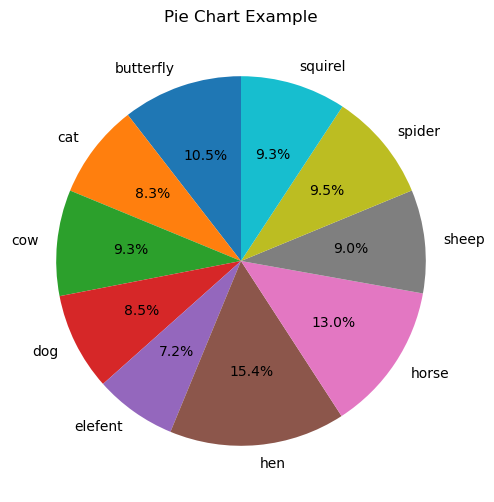

In [12]:
# Create pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size
plt.pie(image_count, labels=categories, autopct='%1.1f%%', startangle=90)  # Add percentage and rotation
plt.title('Pie Chart Example')  # Title for the chart
plt.show()


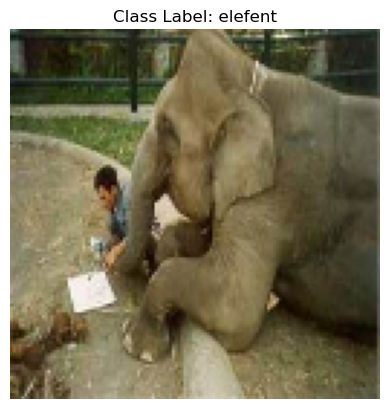

In [13]:
random_row = img_data.sample(n=1).iloc[0]
image = random_row["valid_image"]
class_label = random_row["class_label"]

# Display the image and class label
plt.imshow(image)
plt.title(f"Class Label: {class_label}")
plt.axis("off")
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [15]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target column
img_data['class_label'] = label_encoder.fit_transform(img_data['class_label'])

# Mapping of labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label Mapping: {label_mapping}")


Label Mapping: {'butterfly': 0, 'cat': 1, 'cow': 2, 'dog': 3, 'elefent': 4, 'hen': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirel': 9}


In [16]:
train_df, test_df = train_test_split(img_data, test_size=0.3, random_state=42)  # 70% train, 30% temp


In [17]:

def prepare_data(dataframe):
    images = np.stack(dataframe["valid_image"].values)  # Stack images into a NumPy array
    labels = dataframe["class_label"].values
    return images, labels

# Prepare datasets
x_train, y_train = prepare_data(train_df)
#x_val, y_val = prepare_data(val_df)
x_test, y_test = prepare_data(test_df)

# Normalize pixel values to the range [0, 1]
x_train = x_train / 255.0
#x_val = x_val / 255.0
x_test = x_test / 255.0


In [18]:
len(categories)

10

In [19]:
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
animal_10_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(256, activation='relu'),  # Added dense layer with 128 units
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Output layer with 10 classes
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [44]:
animal_10_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [48]:
early_stoping=EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)   

In [40]:
from datetime import datetime

In [50]:
start= datetime.now()
history = animal_10_model.fit(
    x_train,y_train,
    epochs=30,
    validation_data=(x_test,y_test),
    callbacks = [early_stoping]
)
end = datetime.now()

Train on 14090 samples, validate on 6039 samples
Epoch 1/30
14090/14090 [==============================] - 212s 15ms/sample - loss: 0.8852 - acc: 0.7052 - val_loss: 1.1873 - val_acc: 0.6095
Epoch 2/30
14090/14090 [==============================] - 216s 15ms/sample - loss: 0.6898 - acc: 0.7678 - val_loss: 1.1937 - val_acc: 0.6079
Epoch 3/30
14090/14090 [==============================] - 197s 14ms/sample - loss: 0.4905 - acc: 0.8361 - val_loss: 1.3657 - val_acc: 0.6256
Epoch 4/30
14090/14090 [==============================] - 209s 15ms/sample - loss: 0.3360 - acc: 0.8865 - val_loss: 1.5235 - val_acc: 0.6198
Epoch 5/30
14090/14090 [==============================] - 214s 15ms/sample - loss: 0.2321 - acc: 0.9230 - val_loss: 1.8433 - val_acc: 0.6067
Epoch 6/30
14090/14090 [==============================] - 198s 14ms/sample - loss: 0.1713 - acc: 0.9458 - val_loss: 1.8426 - val_acc: 0.6150


In [72]:
print("time taken: ",end-start)

time taken:  0:20:46.621451


In [54]:
loss, accuracy = animal_10_model.evaluate(x_test,y_test)
print(f'Test Accuracy: {accuracy:.4f}')


6039/6039 [==============================] - 21s 3ms/sample - loss: 1.1873 - acc: 0.6095
Test Accuracy: 0.6095


In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [62]:
y_pred = animal_10_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)



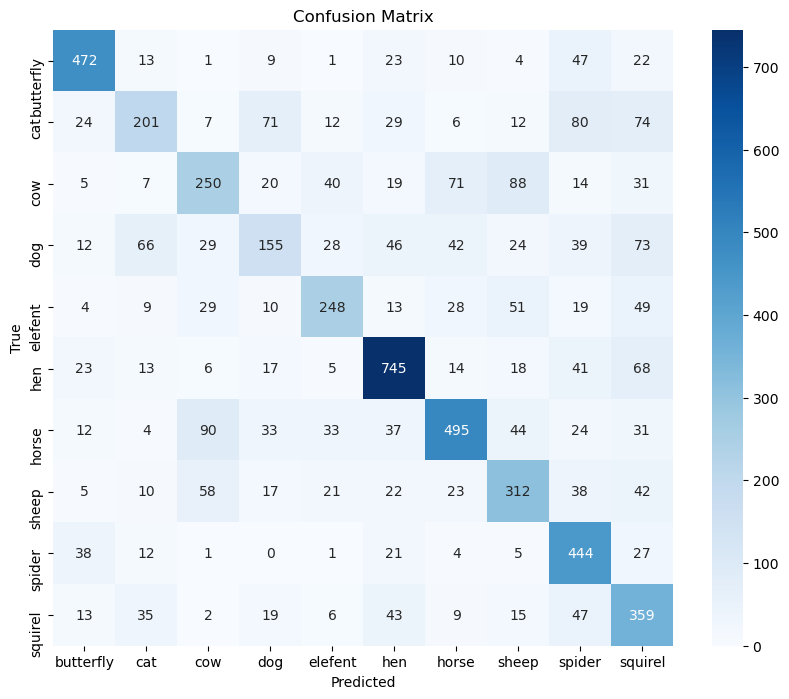

In [68]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [76]:
# Save the entire model
animal_10_model.save("animal_10_model.h5")
